# Final Exam, Spring 2021: Analyzing product reviews #

_Version 1.0.1_

This problem has **9** exercises, numbered 0 to **8**. There are **20 available points.** However, to earn 100%, the threshold is **17 points.** (Therefore, once you hit the threshold, you can stop. There is no extra credit for exceeding it.)

Each exercise builds logically on the previous one, but you may solve them in any order. That is, if you can't solve an exercise, you can still move on and try the next one. **However, if you see a code cell introduced by the phrase, "Sample result for ...", please run it.** Some demo cells in the notebook may depend on these precomputed results.

The point values of individual exercises are as follows:

- Exercise 0: 2 points
- Exercise 1: 2 points
- Exercise 2: 1 point
- Exercise 3: 2 points
- Exercise 4: 2 point
- Exercise 5: 2 points
- Exercise 6: 3 points
- Exercise 7: 2 points
- Exercise 8: 4 points

**Pro-tips.**
- All test cells use **randomly generated inputs.** Therefore, try your best to write solutions that do not assume too much. To help you debug, when a test cell does fail, it will often tell you exactly what inputs it was using and what output it expected, compared to yours.
- If you need a complex SQL query, remember that you can define one using a [triple-quoted (multiline) string](https://docs.python.org/3.7/tutorial/introduction.html#strings).
- If your program behavior seem strange, try resetting the kernel and rerunning everything.
- If you mess up this notebook or just want to start from scratch, save copies of all your partial responses and use `Actions` $\rightarrow$ `Reset Assignment` to get a fresh, original copy of this notebook. _(Resetting will wipe out any answers you've written so far, so be sure to stash those somewhere safe if you intend to keep or reuse them!)_
- If you generate excessive output (e.g., from an ill-placed `print` statement) that causes the notebook to load slowly or not at all, use `Actions` $\rightarrow$ `Clear Notebook Output` to get a clean copy. The clean copy will retain your code but remove any generated output. **However**, it will also **rename** the notebook to `clean.xxx.ipynb`. Since the autograder expects a notebook file with the original name, you'll need to rename the clean notebook accordingly. Be forewarned: we won't manually grade "cleaned" notebooks if you forget!

**Good luck!**

## Problem goal: Category mining ##

In this problem, your goal is to analyze a product-reviews dataset from the Amazon Kindle Store, which sells electronic books (e-books). The observations consist of about 1 million product reviews, where for each review, a user rates a book on a scale of 1-5 and then writes a short comment.

Suppose that you only know which users reviewed which e-books. But your hunch is that users interested in a certain type of book (e.g., books about business or sports) tend to rate and review similar books. You'll test this hunch, by running a _spectral co-clustering_ of a user-product graph to see how books cluster.

The clustering code comes from the [scikit-learn](https://scikit-learn.org/stable/) package, so you won't have to build that from scratch. However, the hard work you'll do is preparing the data and postprocessing the results. Welcome to data analysis in the wild.

## Setup ##

Run the code cell below, which will load some utilities that the notebook needs, as well as some common modules that you may need. (As always, you can use other modules, too, if they are available on Vocareum; however, it is _your_ responsibility to make sure they work.)

In [1]:
###
### AUTOGRADER TEST - DO NOT REMOVE
###

!date
global_overwrite = False
from testing_tools import get_mem_usage_GiB
print(get_mem_usage_GiB())
!date

# Some things *we* need...
from pprint import pprint
from testing_tools import load_json, plot_spy

# Some things *you* might need...
import re
import pandas as pd
import numpy as np
import scipy as sp

Sat 22 Apr 2023 05:16:06 AM PDT
Opening pickle from './resource/asnlib/publicdata/reviews_df.pickle' ...
Opening pickle from './resource/asnlib/publicdata/metadata_df.pickle' ...
Opening pickle from './resource/asnlib/publicdata/combined_df.pickle' ...
Opening pickle from './resource/asnlib/publicdata/maps.pickle' ...
Opening pickle from './resource/asnlib/publicdata/ratings_matrix.pickle' ...
Opening pickle from './resource/asnlib/publicdata/ebook_labels.pickle' ...
Opening pickle from './resource/asnlib/publicdata/top_k_ebook_labels.pickle' ...
Opening pickle from './resource/asnlib/publicdata/labeled_metadata_df.pickle' ...
Opening pickle from './resource/asnlib/publicdata/top_cluster_genres.pickle' ...
1.4 GiB
Sat 22 Apr 2023 05:16:09 AM PDT


## Part A: Data cleaning (contains Exercises 0 and 1) ##

We need to clean two parts of the dataset.

### Part A-0: Reviews ###

The first part are the reviews. The code cell below loads them into a list of dictionaries named `raw_reviews`:

In [2]:
!date
raw_reviews = load_json('kindle_reviews.json', line_by_line=True)

print(f'\n==> Found {len(raw_reviews):,} e-book reviews. Here are the first two:\n')
pprint(raw_reviews[:2])
print(get_mem_usage_GiB())
!date

Sat 22 Apr 2023 05:16:09 AM PDT
'./resource/asnlib/publicdata/kindle_reviews.json': 982619

==> Found 982,619 e-book reviews. Here are the first two:

[{'asin': 'B000F83SZQ',
  'helpful': [0, 0],
  'overall': 5.0,
  'reviewText': 'I enjoy vintage books and movies so I enjoyed reading this '
                "book.  The plot was unusual.  Don't think killing someone in "
                'self-defense but leaving the scene and the body without '
                'notifying the police or hitting someone in the jaw to knock '
                'them out would wash today.Still it was a good read for me.',
  'reviewTime': '05 5, 2014',
  'reviewerID': 'A1F6404F1VG29J',
  'reviewerName': 'Avidreader',
  'summary': 'Nice vintage story',
  'unixReviewTime': 1399248000},
 {'asin': 'B000F83SZQ',
  'helpful': [2, 2],
  'overall': 4.0,
  'reviewText': 'This book is a reissue of an old one; the author was born in '
                "1910. It's of the era of, say, Nero Wolfe. The introduction "
          

Each element is an e-book review, stored as a dictionary. The most relevant keys are the following:

* `'reviewerID'`: An ID string for the user who wrote the review.
* `'asin'`: An ID string for the e-book that the user reviewed.
* `'overall'`: The reviewer's rating of the e-book, on a scale of 1.0 (hated the book) to 5.0 (loved the book). The value is shown and stored as a floating-point value, but the stored value is always an integer.
* `'reviewText'`: The reviewer's comments about the book, a string of arbitrary length.
* `'helpful'`: A two-element list. The first element is the number of other users who marked this review as being "helpful"; the second element is the number of users who looked at the review. For example, a value of `[4, 7]` means that 7 users read the review, but only 4 marked it as "helpful."

### Exercise 0 (2 points): Convert the reviews into a pandas data frame ###

Complete the function, `reviews_to_df(reviews)`, below. Given a raw reviews dataset named `reviews`, which is a list of dictionaries like the one shown above, your function should convert it to a pandas `DataFrame` object and return that dataframe. Each row of the dataframe will be a book review; your function should organize the dataframe as **six** columns, constructed as follows:

1. `'reviewer'`: A string ID for the reviewer, which is the value of `'reviewerID'`
2. `'ebook'`: A string ID for the e-book, which is the value of `'asin'`
3. `'rating'`: An **integer** value, which is the `'overall'` rating converted into an integer value
4. `'text'`: A string holding the reviewer's text comments, taken from `'reviewText'`
5. `'num_helpful'`: An integer for the number of users who thought the review was helpful, taken from the first field of the `'helpful'` value
6. `'num_evals'`: An integer for the number of users who evaluated the review, taken from the second field of the `'helpful'` value

For example, suppose `reviews` has exactly these two elements:

```python
[{'asin': 'B000F83SZQ', 'helpful': [0, 0], 'overall': 5.0, 'reviewerID': 'A1F6404F1VG29J',
  'reviewText': 'I enjoy vintage books ... good read for me.',
  ... },
 {'asin': 'B000F83SZQ', 'helpful': [2, 2], 'overall': 4.0, 'reviewerID': 'AN0N05A9LIJEQ',
  'reviewText': 'This book is ... well worth a look-see.',
  ...}
]
```

Then the output would be a `DataFrame` of the form:

|    | reviewer       | ebook      |   rating | text                                        |   num_helpful |   num_evals |
|---:|:---------------|:-----------|---------:|:--------------------------------------------|--------------:|------------:|
|  0 | A1F6404F1VG29J | B000F83SZQ |        5 | I enjoy vintage books ... good read for me. |             0 |           0 |
|  1 | AN0N05A9LIJEQ  | B000F83SZQ |        4 | This book is ... well worth a look-see.     |             2 |           2 |

> _Note 0:_ Your function must _not_ modify the input, `reviews`. The test cell will check for that and may fail with strange errors if you do so.
>
> _Note 1:_ The test code uses randomly generated inputs. Your function should _only_ depend on the presence of the keys, `'reviewerID'`, `'asin'`, `'helpful'`, `'overall'`, and `'reviewText'`, which you need to construct the output. The test inputs may or may not contain other keys with randomly generated names.
>
> _Note 2:_ The order of rows does not matter, as the test cell will use tibble comparison functions.

In [3]:
def reviews_to_df(reviews):
    
    keys = ['reviewerID', 'asin', 'overall', 'reviewText']


    df = pd.DataFrame([{k: rev[k] for k in keys} for rev in reviews])
    
    df['overall'] = df['overall'].astype(int)
    
    df['num_helpful'] = pd.DataFrame(rev['helpful'][0] for rev in reviews)
    
    df['num_evals'] = pd.DataFrame(rev['helpful'][1] for rev in reviews)
    
    df = df.rename(columns={'reviewerID': 'reviewer', 'asin': 'ebook', 'reviewText': 'text',  'overall': 'rating'})  
    
    return df


# reviews_pared = [{'reviewer': r['reviewerID'],
#                       'ebook': r['asin'],
#                       'rating': int(r['overall']),
#                       'text': r['reviewText'],
#                       'num_helpful': r['helpful'][0],
#                       'num_evals': r['helpful'][1]}
#                     for r in reviews]
#     return DataFrame(reviews_pared)

In [4]:
# Demo:
ex1_demo_reviews = \
    [{'asin': 'B000F83SZQ', 'helpful': [0, 0], 'overall': 5.0, 'reviewerID': 'A1F6404F1VG29J',
      'reviewText': 'I enjoy vintage books ... good read for me.'},
     {'asin': 'B000F83SZQ', 'helpful': [2, 2], 'overall': 4.0, 'reviewerID': 'AN0N05A9LIJEQ',
      'reviewText': 'This book is ... well worth a look-see.'}]

reviews_to_df(ex1_demo_reviews)

,reviewer,ebook,rating,text,num_helpful,num_evals
0,A1F6404F1VG29J,B000F83SZQ,5,I enjoy vintage books ... good read for me.,0,0
1,AN0N05A9LIJEQ,B000F83SZQ,4,This book is ... well worth a look-see.,2,2


In [5]:
# Test cell: `fx_ex0_reviews_to_df` (2 points)

###
### AUTOGRADER TEST - DO NOT REMOVE
###

from testing_tools import fx_ex0__check
print("Testing...")
for trial in range(100):
    fx_ex0__check(reviews_to_df)

reviews_to_df__passed = True
print(get_mem_usage_GiB())
print("\n(Passed!)")

Testing...
4.1 GiB

(Passed!)


### Sample results for Exercise 0: `reviews_to_df` => `reviews_df` ###

If you had a working solution to Exercise 0, then in principle you could use it to generate a reviews `DataFrame` from the `raw_reviews` input. We have precomputed these for you; run the cell below to load this dataframe, which will be stored in the global variable, `reviews_df`.

> Note 0: **Read and run this cell even if you skipped or otherwise did not complete Exercise 0.**
>
> Note 1: This cell **deletes** the original `raw_reviews` input to help save memory. Therefore, you should not have to write any code that depends on it.

In [6]:
from testing_tools import fx_reviews_df as reviews_df

print("\nExamples:")
display(reviews_df.head())
    
print("\nDeleting `raw_reviews`...")
if 'raw_reviews' in globals(): del raw_reviews
print(get_mem_usage_GiB())
print('Done.')


Examples:


,reviewer,ebook,rating,text,num_helpful,num_evals
0,A1F6404F1VG29J,B000F83SZQ,5,I enjoy vintage books and movies so I enjoyed ...,0,0
1,AN0N05A9LIJEQ,B000F83SZQ,4,This book is a reissue of an old one; the auth...,2,2
2,A795DMNCJILA6,B000F83SZQ,4,This was a fairly interesting read. It had ol...,2,2
3,A1FV0SX13TWVXQ,B000F83SZQ,5,I'd never read any of the Amy Brewster mysteri...,1,1
4,A3SPTOKDG7WBLN,B000F83SZQ,4,"If you like period pieces - clothing, lingo, y...",0,1



Deleting `raw_reviews`...
2.5 GiB
Done.


### Part A-1: E-book metadata ###

For many of the e-books, there is also some additional metadata. Run the code cell below, which will load these metadata separately into a list of nested dictionaries called `raw_metadata`:

In [7]:
!date
raw_metadata = load_json('kindle_metadata-2018.json', line_by_line=True)
print(f'\n==> Found {len(raw_metadata):,} e-books.')
get_mem_usage_GiB()
!date

Sat 22 Apr 2023 05:16:25 AM PDT
'./resource/asnlib/publicdata/kindle_metadata-2018.json': 491670

==> Found 491,670 e-books.
Sat 22 Apr 2023 05:16:40 AM PDT


These data are messy. Here is what it looks like for one e-book:

In [8]:
pprint(raw_metadata[0])

{'also_buy': ['B007NLCJBC', 'B01FARODH8'],
 'also_view': ['B000FBF81K', 'B00PBDMER8'],
 'asin': 'B000FA5KKA',
 'brand': 'Arthur K. Barnes',
 'category': ['Kindle Store', 'Kindle eBooks', 'Science Fiction & Fantasy'],
 'date': '',
 'description': [],
 'details': {'ASIN:': 'B000FA5KKA',
             'File Size:': '295 KB',
             'Language:': 'English',
             'Lending:': 'Enabled',
             'Print Length:': '113 pages',
             'Publication Date:': 'October 14, 2001',
             'Publisher:': 'FuturesPast Editions (October 14, 2001)',
             'Word Wise:': 'Enabled'},
 'feature': [],
 'fit': '',
 'image': [],
 'main_cat': 'Buy a Kindle',
 'price': '',
 'rank': '1,716,849 Paid in Kindle Store (',
 'similar_item': '',
 'tech1': '',
 'tech2': '',
 'title': ''}


For our analyses, we only need two pieces of information: the **book ID** (the first `'asin'` value) and the **genre** (element 2 of the `'category'` value, which has 3 elements in the above example).

The problem is that the genres can be messy. Here are some examples of what can appear in the category list:

In [9]:
print('   4:', raw_metadata[4]['category']) # Looks fine ...
print('   1:', raw_metadata[1]['category']) # 4 elements; but element 2 is still valid
print(' 244:', raw_metadata[244]['category']) # 2 elements
print('2890:', raw_metadata[2890]['category']) # 3 elements, but element 2 has "junk" in it
print('   9:', raw_metadata[9]['category']) # 3 elements, but element 2 has '&amp;' instead of '&'

   4: ['Kindle Store', 'Kindle eBooks', 'Business & Money']
   1: ['Kindle Store', 'Kindle eBooks', 'Engineering & Transportation', '</span>']
 244: ['Kindle Store', 'Kindle eBooks']
2890: ['Kindle Store', 'Kindle eBooks', '</span>']
   9: ['Kindle Store', 'Kindle eBooks', 'Business &amp; Money']


**Usable genres.** For any e-book, we will say that it has a **usable genre** if the following conditions hold:

1. Its `'category'` list has **at least** three elements (`>= 3`).
2. The first two elements of the `'category'` list **equal** `'Kindle Store'` and `'Kindle eBooks'`, respectively.
3. The third element does **not** contain any angle brackets (`'<'` and `'>'`).

Thus, examples 4, 1, and 9 above have usable genres, but 244 and 2890 do not.

### Exercise 1 (2 points): Subselect e-books with usable genres ###

Suppose you are given a collection of metadata named `metadata`, which is formatted like what you see above. Complete the function `metadata_to_df(metadata)` so that it creates and returns a new pandas `DataFrame` containing only those e-books with usable genres, as defined above.

In particular, the new dataframe should have one row per e-book. It should also have two columns:

1. `'ebook'`, a string ID for the e-book, taken from the first `'asin'` field
2. `'genre'`, a **cleaned** genre string, taken from element 2 of the `'category'` value

A cleaned genre string is one where any instance of the substring, `&amp;`, is replaced by `&`. For example, if the input genre string is `'Business &amp; Money'`, then its cleaned version is `'Business & Money'`.

**Example.** Suppose `metadata` equals the following:

```python
    [{'asin': 'B000FA5KKA',
      'category': ['Kindle Store', 'Kindle eBooks', 'Science Fiction & Fantasy']},
     {'asin': 'B000FA5M3K',
      'category': ['Kindle Store', 'Kindle eBooks', 'Engineering & Transportation', '</span>']},
     {'asin': 'B000FA5KX2',
      'category': ['Kindle Store', 'Kindle eBooks', 'Business & Money']},
     {'asin': 'B000FA5L2C',
      'category': ['Kindle Store', 'Kindle eBooks', 'Business &amp; Money']},
     {'asin': 'B000FC2LCS',
      'category': ['Kindle Store', 'Kindle eBooks']},
     {'asin': 'B001CBBL7M',
      'category': ['Kindle Store', 'Kindle eBooks', '</span>']}]
```

Then your function would return a dataframe equivalent to this one:

|    | ebook      | genre                        |
|---:|:-----------|:-----------------------------|
|  0 | B000FA5KKA | Science Fiction & Fantasy    |
|  1 | B000FA5M3K | Engineering & Transportation |
|  2 | B000FA5KX2 | Business & Money             |
|  3 | B000FA5L2C | Business & Money             |

> _Note 0:_ Your function must _not_ modify the input, `metadata`. The test cell will check for that and may fail with strange errors if you do so.
>
> _Note 1:_ The test code uses randomly generated inputs. Your function should _only_ depend on the presence of the keys, `'asin'` and `'category'`, which you need to construct the output. The test inputs may or may not contain other keys with randomly generated names.
>
> _Note 2:_ The order of rows does not matter, as the test cell will use tibble comparison functions.
>
> _Note 3:_ You may assume there will always be at least one e-book with a usable genre.

In [153]:
def metadata_to_df(metadata):
    
    from pandas import DataFrame
    
    def is_usable(m):
        c = m['category']
        return len(c) >= 3 \
               and (c[0] == 'Kindle Store') and (c[1] == 'Kindle eBooks') \
               and ('<' not in c[2]) and ('>' not in c[2])
    def clean_genre(m):
        return m['category'][2].replace('&amp;', '&')
    
    metadata_pared = [{'ebook': m['asin'],
                       'genre': clean_genre(m)} for m in metadata if is_usable(m)]
    return DataFrame(metadata_pared)


In [154]:
# Demo
ex1_demo_metadata = \
    [{'asin': 'B000FA5KKA',
      'category': ['Kindle Store', 'Kindle eBooks', 'Science Fiction & Fantasy']},
     {'asin': 'B000FA5M3K',
      'category': ['Kindle Store', 'Kindle eBooks', 'Engineering & Transportation', '</span>']},
     {'asin': 'B000FA5KX2',
      'category': ['Kindle Store', 'Kindle eBooks', 'Business & Money']},
     {'asin': 'B000FA5L2C',
      'category': ['Kindle Store', 'Kindle eBooks', 'Business &amp; Money']},
     {'asin': 'B000FC2LCS',
      'category': ['Kindle Store', 'Kindle eBooks']},
     {'asin': 'B001CBBL7M',
      'category': ['Kindle Store', 'Kindle eBooks', '</span>']}]

metadata_to_df(ex1_demo_metadata)

,ebook,genre
0,B000FA5KKA,Science Fiction & Fantasy
1,B000FA5M3K,Engineering & Transportation
2,B000FA5KX2,Business & Money
3,B000FA5L2C,Business & Money


In [155]:
# Test cell: `fx_ex1_metadata_to_df` (2 points)

###
### AUTOGRADER TEST - DO NOT REMOVE
###

from testing_tools import fx_ex1__check
print("Testing...")
for trial in range(100):
    fx_ex1__check(metadata_to_df)

metadata_to_df__passed = True
print(get_mem_usage_GiB())
print("\n(Passed!)")

Testing...
5.0 GiB

(Passed!)


### Sample results for Exercise 1: `metadata_to_df` => `metadata_df` ###

If you had a working solution to Exercise 1, then in principle you could use it to generate a metadata dataframe from the `raw_metadata` input. Instead, we have precomputed that for you; run the cell below to load this dataframe, which will be stored in the global variable, `metadata_df`.

> Note 0: **Read and run this cell even if you skipped or otherwise did not complete Exercise 1.**
>
> Note 1: This cell **deletes** the original `raw_metadata` input to help save memory. Therefore, you should not have to write any code that depends on it.

In [ ]:
from testing_tools import fx_metadata_df as metadata_df

print("\nExamples:")
display(metadata_df.head())

print(f"\nIncidentally, there appear to be {len(metadata_df['genre'].unique())} unique genres.")
    
print("\nDeleting `raw_metadata`...")
if 'raw_metadata' in globals(): del raw_metadata
print(get_mem_usage_GiB())
print('Done.')

### Exercise 2 (1 point): Combining the data ###

To simplify your work later, let's combine these separate dataframes into a single one. Complete the function, `combine_dfs(reviews_df, metadata_df)`, so that it returns a new dataframe with the following properties:

1. There is one review per row
2. The dataframe has seven (7) columns, which essentially combine all columns from the two dataframes: `'reviewer'`, `'ebook'`, `'rating'`, `'text'`, `'num_helpful'`, `'num_evals'`, and `'genre'`
3. Any review whose `'ebook'` is **missing** from `metadata_df` should be omitted

> _Note 0:_ Your function must _not_ modify the input dataframes. The test cell will check for that and may fail with strange errors if you do so.
>
> _Note 1:_ The order of rows does not matter, as the test cell will use tibble comparison functions.

In [ ]:
def combine_dfs(reviews_df, metadata_df):
    
    metadata_df = metadata_df.dropna(subset=['ebook'])
    df = pd.merge(reviews_df, metadata_df, on='ebook')
    
    return df


In [ ]:
# Demo: Should reduce the number of reviews to `484,708`
print(f"`reviews_df` has {len(reviews_df):,} reviews (rows).")

ex2_demo_result = len(combine_dfs(reviews_df, metadata_df))
print(f"Combining with `metadata_df` leaves {ex2_demo_result:,} reviews.")

In [ ]:
# Test cell: `fx_ex2_combine_dfs` (1 point)

###
### AUTOGRADER TEST - DO NOT REMOVE
###

from testing_tools import fx_ex2__check
print("Testing...")
for trial in range(100):
    fx_ex2__check(combine_dfs)

combine_dfs__passed = True
print(get_mem_usage_GiB())
print("\n(Passed!)")

### Sample results for Exercise 2: `combine_dfs` => `combined_df` ###

If you had a working solution to Exercise 1, then in principle you could use it to generate a combined input. We have precomputed this result for you; run the cell below to load this dataframe, which will be stored in the global variable, `combined_df`.

> Note 0: **Read and run this cell even if you skipped or otherwise did not complete Exercise 2.**
>
> Note 1: This cell **deletes** `reviews_df` to help save memory. Therefore, you should not have to write any additional code that depends on it below.

In [ ]:
from testing_tools import fx_combined_df as combined_df

print("\nExamples:")
display(combined_df.head())
    
print("\nDeleting `reviews_df` ...")
if 'reviews_df' in globals(): del reviews_df
print(get_mem_usage_GiB())
print('Done.')

## Part B: Discovering genres? (Exercises 3-5) ##

Each review connects a user to a book. Suppose we want to cluster users into groups based on what books they reviewed; or similarly, suppose we want to cluster books together based on who reviewed them. This kind of clustering between **two** times of objects is sometimes referred to as a **biclustering** problem.

To do a biclustering, we first need to build a (sparse) matrix that encodes these connections. Here is one way. Let $A$ an $m \times n$ matrix of $m$ users (rows) and $n$ books (columns). Let each entry $a_{i, j}$ be the rating that user $i$ gave to book $j$. With such a matrix, we can then use a biclustering algorithm called _spectral co-clustering_ to construct both user-user and book-book clusters.

### Exercise 3 (2 points): Map string IDs to logical indices ###

Suppose you are given a pandas `Series` object, `x`, whose values are strings. For example, suppose `x` is the following `Series`:

|    x     |
|:--------:|
|   cat    |
|   dog    |
|   cat    |
|   cat    |
| aardvark |
|   dog    |
| anemone  |
| aardvark |

Write a function, `create_map(x)`, so that it does the following:

1. It determines the unique values in `x`.
2. It sorts these unique values in ascending order.
3. It assigns each unique value to a unique integer, starting from 0 and corresponding to the value's position in sorted order.
4. It constructs and returns a Python dictionary that maps `x`-values (keys) to integers (values).

For instance, for the preceding `x`, the unique sorted values would be _aardvark_, _anemone_, _cat_, and _dog_. Therefore, we would assign _aardvark_ to 0, _anemone_ to 1, _cat_ to 2, and _dog_ to 3. Therefore, the function would return the dictonary,

```python
   {'aardvark': 0, 'anemone': 1, 'cat': 2, 'dog', 3}
```

> _Note:_ Your function must _not_ modify the input `Series`, `x`. The test cell will check for that and may fail with strange errors if you do so.

In [ ]:
def create_map(x):
    assert isinstance(x, pd.Series)
    
    sorted_unique_series = sorted(x.unique())
    
    return {v: i for i, v in enumerate(sorted_unique_series)}


#     values = x.unique()
#     values.sort()
#     return {value: index for value, index in zip(values, range(len(values)))}


In [ ]:
# Demo
ex3_demo_input = pd.Series(['cat', 'dog', 'cat', 'cat', 'aardvark', 'dog', 'anemone', 'aardvark'])
create_map(ex3_demo_input)

In [ ]:
# Test cell: `fx_ex3_create_map` (2 points)

###
### AUTOGRADER TEST - DO NOT REMOVE
###

from testing_tools import fx_ex3__check
print("Testing...")
for trial in range(200):
    fx_ex3__check(create_map)

create_map__passed = True
print(get_mem_usage_GiB())
print("\n(Passed!)")

### Sample results for Exercise 3, `create_map` => `reviewer_map` and `ebook_map` ###

If you had a working solution to Exercise 3, then in principle you could use it to generate index maps for both reviewers and e-books. We have precomputed this result for you; run the cell below create two value-to-index maps: `reviewer_map` for users (reviewers) and `ebook_map` for e-books.

> Note: **Read and run this cell even if you skipped or otherwise did not complete Exercise 3.**

In [ ]:
from testing_tools import fx_reviewer_map as reviewer_map
from testing_tools import fx_ebook_map as ebook_map
print(get_mem_usage_GiB())

print('A3SZMGJMV0G16C', "==>", reviewer_map['A3SZMGJMV0G16C'])
print('B000FA64PK', "==>", ebook_map['B000FA64PK'])

### Exercise 4 (2 points): Build a sparse matrix ###

Suppose you are given a dataframe, `ratings`, with three columns:

* `'reviewer'`: The string ID of a user
* `'ebook'`: The string ID of a book that the user rated
* `'rating'`: The value of the user's rating, which is an integer from 1 to 5.

In addition, suppose you are given string-to-integer maps for reviewers and e-books, as `r_map` and `e_map`, respectively.

Complete the function, `ratings_to_coo(ratings, r_map, e_map)`, so that it returns a Scipy sparse matrix in COO (coordinate) format, constructed according to these rules:

1. Let `(r, e, v)` denote the values of `'reviewer'`, `'ebook'`, and `'rating'` in a row of `ratings`. Each row will be a nonzero of the sparse matrix.
2. The reviewer with string ID `r` corresponds to row `i = r_map[r]` of the sparse matrix.
3. An e-book with string ID `e` corresponds to column `j = e_map[e]` of the sparse matrix.
4. The `(i, j)` entry of the sparse matrix is `v`.

To get you started, the function below imports [Scipy's `coo_matrix` function](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.coo_matrix.html), which you should use to construct your matrix. The starter code also determines the shape (number of rows and columns) for you. Use the `dtype=int` argument to ensure the nonzero values are stored as integers.

**Example.** Suppose `ratings` is as follows:

| reviewer   | ebook   |   rating |
|:-----------|:--------|---------:|
| alice      | happy   |        5 |
| bob        | sad     |        2 |
| carol      | happy   |        5 |
| dave       | happy   |        4 |
| edith      | sad     |        1 |

Next, suppose `r_map` and `e_map` are as follows:

```python
r_map = {'alice': 0, 'bob': 1, 'carol': 2, 'dave': 3, 'edith': 4}
e_map = {'happy': 0, 'sad': 1}
```

Then the sparse matrix would have a structure that looks like the following (rendered here as a table for ease of visualization):

|         | _col 0_ | _col 1_ |
|:-------:|:-------:|:-------:|
| _row 0_ |    5    |         |
| _row 1_ |         |    2    |
| _row 2_ |    5    |         |
| _row 3_ |    4    |         |
| _row 4_ |         |    1    |

> _Note:_ Your function must _not_ modify the input dataframe, `ratings`, or the index mappings, `r_map` and `e_map`. The test cell will check for that and may fail with strange errors if you do so.

In [49]:
def ratings_to_coo(ratings, r_map, e_map):
    from scipy.sparse import coo_matrix
    
    # Precompute the matrix shape, `m` rows by `n` columns:
    m, n = max(r_map.values())+1, max(e_map.values())+1
    
    rows = ratings['reviewer'].map(r_map)
    cols = ratings['ebook'].map(e_map)
    values = ratings['rating']
    
    matrix = coo_matrix((values, (rows, cols)), shape=(m, n))
    
    return matrix


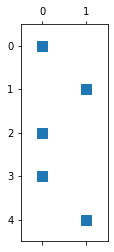

In [50]:
# Demo:
ex4_demo_ratings = pd.DataFrame({'reviewer': ['alice', 'bob', 'carol', 'dave', 'edith'],
                                 'ebook': ['happy', 'sad', 'happy', 'happy', 'sad'],
                                 'rating': [5, 2, 5, 4, 1]})
ex4_demo_r_map = {'alice': 0, 'bob': 1, 'carol': 2, 'dave': 3, 'edith': 4}
ex4_demo_e_map = {'happy': 0, 'sad': 1}

ex4_demo_matrix = ratings_to_coo(ex4_demo_ratings, ex4_demo_r_map, ex4_demo_e_map)
plot_spy(ex4_demo_matrix)

In [51]:
# Test cell: `fx_ex4_ratings_to_coo` (2 points)

###
### AUTOGRADER TEST - DO NOT REMOVE
###

from testing_tools import fx_ex4__check
print("Testing...")
for trial in range(100):
    fx_ex4__check(ratings_to_coo)

ratings_to_coo__passed = True
print(get_mem_usage_GiB())
print("\n(Passed!)")

Testing...
4.9 GiB

(Passed!)


### Sample results for Exercise 4, `ratings_to_coo` => `ratings_matrix` ###

If you had a working solution to Exercise 4, then in principle you could use it to generate a sparse matrix for the Amazon Kindle ratings data. We have precomputed this result for you; run the cell below create the sparse matrix, which is stored in the variable, `ratings_matrix`.

> Note: **Read and run this cell even if you skipped or otherwise did not complete Exercise 4.**

The `ratings_matrix` is (65,997 users) x (31,765 e-books), with 484,708 nonzero ratings.
Here is a picture:
4.9 GiB


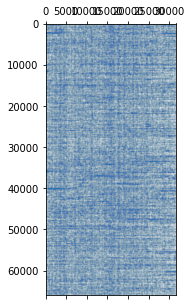

In [52]:
from testing_tools import fx_ratings_matrix as ratings_matrix

print(f"The `ratings_matrix` is ({ratings_matrix.shape[0]:,} users) x ({ratings_matrix.shape[1]:,} e-books), with {ratings_matrix.nnz:,} nonzero ratings.")
print("Here is a picture:")
plot_spy(ratings_matrix, figsize=(5, 5), markersize=0.005)
print(get_mem_usage_GiB())

### Spectral co-clustering ###

The `scikit-learn` package provides a spectral co-clustering implementation. It takes your sparse matrix as input, as well as a target number of clusters; it returns an assignment of rows and columns to clusters, as we'll explain below.

Let's start by computing this clustering. As it happens, there are roughly 30 different usable genres, so let's ask for 30 clusters. The output will consist of two sets of labels, one for users (in a Numpy array named `row_labels`, below) and one for e-books (`col_labels`).

> There are more principled ways to select the number of clusters, but let's save that for your next (O)MSA/VMM class!

In [53]:
def bicluster(matrix, num_clusters=10, verbose=True):
    from sklearn.cluster import SpectralCoclustering
    if verbose:
        print("Performing a biclustering...")
        print(f"* Input matrix shape: {matrix.shape[0]:,} x {matrix.shape[1]:,}")
        print(f"* Number of nonzeros: {matrix.nnz:,}")
        print(f"* Desired number of clusters: {num_clusters}")
    clustering = SpectralCoclustering(n_clusters=num_clusters, random_state=0).fit(matrix)
    if verbose:
        print("==> Done!")
    return clustering.row_labels_, clustering.column_labels_

!date
row_labels, col_labels = bicluster(ratings_matrix, num_clusters=30)
!date

Sat 22 Apr 2023 05:37:20 AM PDT
Performing a biclustering...
* Input matrix shape: 65,997 x 31,765
* Number of nonzeros: 484,708
* Desired number of clusters: 30


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f5dc02535e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/usr/local/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/usr/local/lib/python3.8/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/usr/local/lib/python3.8/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f5daa271c10>
Traceback 

==> Done!
Sat 22 Apr 2023 05:37:25 AM PDT


Let's focus on the e-book (column) labels. Here are the computed labels for the first eight e-books:

In [54]:
print(f"\nHere are the first few column (e-book) labels: {col_labels[:8]}")


Here are the first few column (e-book) labels: [24 24 24 24 25 25  0 25]


The labels are arbitrary integers. E-books belonging to the same cluster will have the same label.

### Exercise 5: Postprocessing the results (2 points) ###

Suppose you are given two inputs, `x_map` and `labels`, formatted as follows:

- `x_map` is a dictionary just like `reviewer_map` and `ebook_map` from Exercise 3: each key `s` is a string ID, and the corresponding value `i = x_map[s]` is its integer index.
- `labels` is a Numpy array holding cluster labels. For an integer index `i`, the value `labels[i]` is the label assigned to `i`.

Complete the function, `map_labels(x_map, labels)` so that it returns a Python dictionary where each key is a string label `s` and the value is its assigned label.

**Example.** Suppose

```python
x_map = {'alice': 0, 'bob': 1, 'carol': 2, 'dave': 3, 'edith': 4}
labels = np.array([1, 0, 1, 1, 0])
```

Then

```python
map_labels(x_map, labels) == {'alice': 1, 'bob': 0, 'carol': 1, 'dave': 1, 'edith': 0}
```

> _Note:_ Your function must _not_ modify the inputs, `x_map` and `labels`. The test cell will check for that and may fail with strange errors if you do so.

In [55]:
def map_labels(x_map, labels):
    
    dic = {}
    
    for k, v in x_map.items():
        dic[k] = labels[v]
        
    return dic


In [56]:
# Demo:
ex5_demo_x_map = {'alice': 0, 'bob': 1, 'carol': 2, 'dave': 3, 'edith': 4}
ex5_demo_labels = np.array([1, 0, 1, 1, 0])
map_labels(ex5_demo_x_map, ex5_demo_labels)

{'alice': 1, 'bob': 0, 'carol': 1, 'dave': 1, 'edith': 0}

In [57]:
# Test cell: `fx_ex5_map_labels` (2 points)

###
### AUTOGRADER TEST - DO NOT REMOVE
###

from testing_tools import fx_ex5__check
print("Testing...")
for trial in range(250):
    fx_ex5__check(map_labels)

map_labels__passed = True
print(get_mem_usage_GiB())
print("\n(Passed!)")

Testing...
5.0 GiB

(Passed!)


### Sample results for Exercise 5, `map_labels` => `ebook_labels` ###

If you had a working solution to Exercise 5, then in principle you could use it to map the e-book labels back to each book's string ID. We have precomputed this result for you; run the cell below create the e-book label map, `ebook_labels`.

> Note: **Read and run this cell even if you skipped or otherwise did not complete Exercise 5.**

In [58]:
from testing_tools import fx_ebook_labels as ebook_labels
print(get_mem_usage_GiB())

print("Some of the assigned labels:")
for ebook_id in ['B00IK5B0LK', 'B00AQNPV0K', 'B007Z3S0NE', 'B0075VFMCI', 'B00C404E60']:
    print(f"* '{ebook_id}' ==> label {ebook_labels[ebook_id]}")

5.0 GiB
Some of the assigned labels:
* 'B00IK5B0LK' ==> label 26
* 'B00AQNPV0K' ==> label 29
* 'B007Z3S0NE' ==> label 0
* 'B0075VFMCI' ==> label 0
* 'B00C404E60' ==> label 26


## Part C: Cluster analysis (contains Exercise 6-8) ##

Let's inspect the e-book clusters and see what they reveal.

### Exercise 6: k-largest clusters (3 points) ###

Suppose we are given a Numpy array of cluster labels called `labels` and an integer `k >= 1`. Complete the function, `top_k_labels(labels, k)`, so that

1. it counts how many times each label occurs;
2. ranks the labels from most-to-least frequent; and
3. returns a **Python set** containing the `k` most frequent labels.

In the case of ties, include all labels with the same count. Therefore, your function might return more than `k` labels. And if there are fewer than `k` distinct labels, then your function should return them all.

For example, consider the array,

```python
labels = np.array([5, 3, 5, 5, 0, 6, 6, 4, 1, 1, 4, 7, 5, 6])
```

Observe that 5 appears four times, 6 appears three times, 1 and 4 both appear twice, and 0, 3, and 7 appear once each. Therefore:

- If `k=1`, your function would return the set `{5}`.
- If `k=2`, your function would return the set `{5, 6}`.
- If `k=3`, your function would return the set `{5, 6, 1, 4}`. That is, even though the caller only asked for the top 3, there is a tie for third place.
- If `k=4`, your function would again return `{5, 6, 1, 4}`.
- For any `k >= 5`, your function would return all unique values, `{5, 6, 1, 4, 0, 3, 7}`.

> _Note 0:_ Your function must _not_ modify the input array, `labels`. The test cell will check for that and may fail with strange errors if you do so.
>
> _Note 1:_ There are many approaches to this exercise. One useful Numpy function is [`bincount`](https://numpy.org/doc/stable/reference/generated/numpy.bincount.html). A useful pandas function is [`nlargest`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.nlargest.html).

In [158]:
def top_k_labels(labels, k):
    assert isinstance(labels, np.ndarray)
    
    return top_k_labels__1(labels, k)

def top_k_labels__0(labels, k):
    from numpy import bincount, arange, argsort
    counts = bincount(labels)
    values = arange(len(counts))
    values_by_frequency = argsort(counts)
    counts_by_frequency = counts[values_by_frequency]
    count_least_frequent = counts_by_frequency[-k:][0]
    final_count_mask = (counts_by_frequency >= count_least_frequent) \
                       & (counts_by_frequency > 0)
    return set(values_by_frequency[final_count_mask])

def top_k_labels__1(labels, k):
    from pandas import DataFrame
    df = DataFrame({'label': labels}) \
         .groupby('label', as_index=False).size() \
         .nlargest(k, 'size', keep='all')
    return set(df['label'].values)


In [159]:
# Demo:
ex6_demo_labels = np.array([5, 3, 5, 5, 0, 6, 6, 4, 1, 1, 4, 7, 5, 6])
print("* Input:", ex6_demo_labels)
print("* Your output:")
for k in range(1, 10):
    print(f"k={k} ==>", top_k_labels(ex6_demo_labels, k))

* Input: [5 3 5 5 0 6 6 4 1 1 4 7 5 6]
* Your output:
k=1 ==> {5}
k=2 ==> {5, 6}
k=3 ==> {1, 4, 5, 6}
k=4 ==> {1, 4, 5, 6}
k=5 ==> {0, 1, 3, 4, 5, 6, 7}
k=6 ==> {0, 1, 3, 4, 5, 6, 7}
k=7 ==> {0, 1, 3, 4, 5, 6, 7}
k=8 ==> {0, 1, 3, 4, 5, 6, 7}
k=9 ==> {0, 1, 3, 4, 5, 6, 7}


In [160]:
# Test cell: `fx_ex6_top_k_labels` (3 points)

###
### AUTOGRADER TEST - DO NOT REMOVE
###

from testing_tools import fx_ex6__check
print("Testing...")
for trial in range(250):
    fx_ex6__check(top_k_labels)

top_k_labels__passed = True
print(get_mem_usage_GiB())
print("\n(Passed!)")

Testing...
5.0 GiB

(Passed!)


### Sample results for Exercise 6, `top_k_labels` => `top_k_ebook_labels` ###

If you had a working solution to Exercise 6, then in principle you could use it to identify the top `k` e-book labels (computed as `col_labels` in Exercise 4). We have precomputed this result for you; run the cell below create the set of top labels, `top_k_ebook_labels`.

> Note: **Read and run this cell even if you skipped or otherwise did not complete Exercise 6.**

In [62]:
from testing_tools import fx_top_k_ebook_labels as top_k_ebook_labels
print(get_mem_usage_GiB())

print(f"The top {len(top_k_ebook_labels)} most frequent e-book labels:")
print(top_k_ebook_labels)

5.0 GiB
The top 5 most frequent e-book labels:
{0, 15, 25, 26, 29}


### Exercise 7: Top genres in each cluster (2 points) ###

Recall that our analysis has assigned some of the e-books to clusters. For instance, here are a few such assignments, taken from `ebook_labels` as computed in Exercise 5:

In [63]:
ex7_demo_ebooks = {'B00BQR4MYG', 'B00BM672WA', 'B00BQK8YEC', 'B005V8XX1Y', 'B004LP2GXE'}
{e: ebook_labels[e] for e in ex7_demo_ebooks}

{'B005V8XX1Y': 0,
 'B004LP2GXE': 15,
 'B00BM672WA': 15,
 'B00BQK8YEC': 12,
 'B00BQR4MYG': 0}

Each of these e-books is associated with a genre, available in the metadata dataframe from Exercise 1:

In [64]:
metadata_df[metadata_df['ebook'].isin(ex7_demo_ebooks)]

NameError: name 'metadata_df' is not defined

**Your task.** Suppose you are given an e-book-to-label mapping, `ebook_labels`, and an e-book metadata dataframe, `metadata`. Complete the function, `merge_labels(metadata, ebook_labels)`, below, so that it does the following:

1. It constructs a new dataframe with three columns: `'ebook'`, `'genre'`, and `'label'`.
2. In this new dataframe, the `'ebook'` and `'genre'` columns come from `metadata`. The `'label'` column comes from `ebook_labels`. In other words, you need to merge the `ebook_labels` labels with `metadata`.
3. Not all e-books in `metadata` will have labels. The new dataframe should **only** include e-books with labels; any other e-book should not appear in it.

> _Note 0:_ Your function must _not_ modify the inputs, `metadata` and `ebook_labels`. The test cell will check for that and may fail with strange errors if you do so.
>
> _Note 1:_ Be sure the column of labels has an integer.
>
> _Note 2:_ Your function should work even if `ebook_labels` is empty (is a dictionary with no keys, or no keys that match any e-book in `metadata`).

In [65]:
def merge_labels(metadata, ebook_labels):
    
    ebook_labels = pd.DataFrame(ebook_labels.items(), columns=['ebook', 'label'])
    
    df = metadata.merge(ebook_labels, on='ebook')
    
    df = df.dropna(subset=['label'])
    
    df['label'] = df['label'].astype('int')
    
    return df

In [66]:
# Demo:
merge_labels(metadata_df, ebook_labels).head()

NameError: name 'metadata_df' is not defined

In [67]:
# Test cell: `fx_ex7_merge_labels` (2 points)

###
### AUTOGRADER TEST - DO NOT REMOVE
###

from testing_tools import fx_ex7__check
print("Testing...")
for trial in range(100):
    fx_ex7__check(merge_labels)

merge_labels__passed = True
print(get_mem_usage_GiB())
print("\n(Passed!)")

Testing...
5.0 GiB

(Passed!)


### Sample results for Exercise 7, `merge_labels` => `labeled_metadata_df` ###

If you had a working solution to Exercise 7, then in principle you could use it to merge `ebook_labels` with `metadata_df`. We have precomputed this result for you; run the cell below create the labeled metadata dataframe, named `labeled_metadata_df`.

> Note: **Read and run this cell even if you skipped or otherwise did not complete Exercise 7.**

In [68]:
from testing_tools import fx_labeled_metadata_df as labeled_metadata_df
print(get_mem_usage_GiB())

labeled_metadata_df.sample(5)

5.0 GiB


,ebook,genre,label
9305,B009KP8YOU,Children's eBooks,15
13747,B00BNQQE8M,Children's eBooks,26
30535,B00KNLRWR0,"Health, Fitness & Dieting",25
29759,B00K67D67Q,Literature & Fiction,0
26753,B00IHPPZNW,"Cookbooks, Food & Wine",25


### Exercise 8 (last exercise!): Genre features (4 points) ###

You now have the building blocks you need to inspect some simple features of each cluster, to see how "distinct" clusters are from one another. Let's do that by analyzing the top genres represented in each cluster.

First, recall that you previously identified the largest clusters:

In [69]:
top_k_ebook_labels

{0, 15, 25, 26, 29}

Next, recall that you assigned e-books to clusters:

In [ ]:
labeled_metadata_df.head(5)

**Your task.** Complete the function, `calc_top_genres(labeled_metadata, top_labels)`, below. It takes as input two objects:

- `labeled_metadata`: A pandas dataframe, formatted like `labeled_metadata_df` above.
- `top_labels`: A Python set of labels, like `top_k_ebook_labels` above.

It should then do the following:

- For each label in `top_labels`, it should determine the **two** most frequently occurring genres among the e-books with that label.
- It should then return a single dataframe with two columns, `'label'` and `'genre'`. Each row should correspond to one (label, genre) pair. And per the preceding bullet, you expect to see two rows per label.

Regarding the number of rows per label, there are two exceptions. First, if a given label only has e-books from one genre, then there will only be one row. Second, if there are ties, then you should retain all pairs, in the same way you would have done in Exercise 6.

> _Note 0:_ Your function must _not_ modify the input arguments. The test cell will check for that and may fail with strange errors if you do so.
>
> _Note 1:_ The order of rows does not matter, as the test cell will use tibble comparison functions.

**Example.** A correct implementation will produce, for the call `calc_top_genres(labeled_metadata_df, top_k_ebook_labels)` on the input dataset, the following result:

|   label | genre                     |
|--------:|:--------------------------|
|       0 | Literature & Fiction      |
|       0 | Romance                   |
|      15 | Children's eBooks         |
|      15 | Literature & Fiction      |
|      25 | Health, Fitness & Dieting |
|      25 | Literature & Fiction      |
|      26 | Science Fiction & Fantasy |
|      26 | Literature & Fiction      |
|      29 | Literature & Fiction      |
|      29 | Romance                   |

Though not definitive, this result does suggest that the clustering captures distinct groups of books, here, for instance, with a cluster having `'Romance'` novels (label 0) being distinct from a cluster with `'Children's eBooks'` (label 15) and from another with `'Health, Fitness & Dieting'` (label 25), for instance.

In [187]:
def calc_top_genres(labeled_metadata, top_labels):
    
    def analyze_one_cluster(df_group):
        assert len(df_group['label'].unique()) == 1 # handles *one* cluster (one group)
        return df_group.groupby(['label', 'genre'], as_index=False).size().nlargest(2, 'size', keep='all')
    
    # 1. Filter by top labels
    is_top = labeled_metadata['label'].isin(top_labels)
    
    # 2. Group by label
    labeled_groups = labeled_metadata[is_top].groupby('label', as_index=False)
        
    # 3. Analyze each group
    results = labeled_groups.apply(analyze_one_cluster)
    
    # 4. Clean-up and return
    return results.drop(columns='size').reset_index(drop=True)


In [188]:
# Demo
calc_top_genres(labeled_metadata_df, top_k_ebook_labels)

,label,genre
0,0,Literature & Fiction
1,0,Romance
2,15,Children's eBooks
3,15,Literature & Fiction
4,25,"Health, Fitness & Dieting"
5,25,Literature & Fiction
6,26,Science Fiction & Fantasy
7,26,Literature & Fiction
8,29,Literature & Fiction
9,29,Romance


In [189]:
# Test cell: `fx_ex8_calc_top_genres` (4 points)

###
### AUTOGRADER TEST - DO NOT REMOVE
###

from testing_tools import fx_ex8__check
print("Testing...")
for trial in range(100):
    fx_ex8__check(calc_top_genres)

calc_top_genres__passed = True
print(get_mem_usage_GiB())
print("\n(Passed!)")

Testing...
5.0 GiB

(Passed!)


### Sample results for Exercise 8, `calc_top_genres` => `top_cluster_genres` ###

If you had a working solution to Exercise 8, then in principle you could use it to determine the top genres in each cluster by combining `labeled_metadata_df` with `top_k_ebook_labels`. We have precomputed this result for you; run the cell below create the dataframe, named `top_cluster_genres`.

> Note: **Read and run this cell even if you skipped or otherwise did not complete Exercise 8.**

In [190]:
from testing_tools import fx_top_cluster_genres as top_cluster_genres
print(get_mem_usage_GiB())

print("* The top genres in each of the largest few clusters:")
display(top_cluster_genres)

5.0 GiB
* The top genres in each of the largest few clusters:


,label,genre
0,0,Literature & Fiction
1,0,Romance
2,15,Children's eBooks
3,15,Literature & Fiction
4,25,"Health, Fitness & Dieting"
5,25,Literature & Fiction
6,26,Science Fiction & Fantasy
7,26,Literature & Fiction
8,29,Literature & Fiction
9,29,Romance


## Fin! ##

Congratulations, you've reached the end of the final exam—and, therefore, the end of the class! Don't forget to restart and run all cells again to make sure it's all working when run in sequence; and make sure your work passes the submission process, as you only get points that the autograder awards.

**Epilogue.** The idea for this problem was inspired by one of your TAs, Ashley Kelly. The data originated with Julian McAuley [here](http://jmcauley.ucsd.edu/data/amazon/).